# Settings

## Imports

In [ ]:
import sys
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Functions

In [ ]:
#@title plot_series
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      label (list of strings)- tag for the line
    """
    plt.figure(figsize=(5, 2))

    if type(series) is tuple:
      for series_num in series:
        plt.plot(time[start:end], series_num[start:end], format)
    else:
      plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Time")
    plt.ylabel("Value")

    if label:
      plt.legend(fontsize=14, labels=label)

    # Overlay a grid on the graph
    plt.grid(True)

    plt.show()

In [ ]:
#@title trend
def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

In [ ]:
#@title seasonality
def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

In [ ]:
#@title noise
def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal

    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

In [ ]:
#@title autocorrelation
def autocorrelation_temp(time, amplitude, seed=None):
    """
    Generates autocorrelated data

    Args:
      time (array of int) - contains the time steps
      amplitude (float) - scaling factor
      seed (int) - number generator seed for repeatability

    Returns:
      ar (array of float) - autocorrelated data
    """

    # Initialize random number generator
    rnd = np.random.RandomState(seed)

    # Initialize array of random numbers equal to the length
    # of the given time steps plus 50
    ar = rnd.randn(len(time) + 50)

    # Set first 50 elements to a constant
    ar[:50] = 100

    # Define scaling factors
    phi1 = 0.5
    phi2 = -0.1

    # Autocorrelate element 51 onwards with the measurement at
    # (t-50) and (t-30), where t is the current time step
    for step in range(50, len(time) + 50):
        ar[step] += phi1 * ar[step - 50]
        ar[step] += phi2 * ar[step - 33]

    # Get the autocorrelated data and scale with the given amplitude.
    # The first 50 elements of the original array is truncated because
    # those are just constant and not autocorrelated.
    ar = ar[50:] * amplitude

    return ar

# more straightforward autocorrelation function which just computes a value from the previous time step
def autocorrelation(time, amplitude, seed=None):
    """
    Generates autocorrelated data

    Args:
      time (array of int) - contains the time steps
      amplitude (float) - scaling factor
      seed (int) - number generator seed for repeatability

    Returns:
      ar (array of float) - generated autocorrelated data
    """

    # Initialize random number generator
    rnd = np.random.RandomState(seed)

    # Initialize array of random numbers equal to the length
    # of the given time steps plus an additional step
    ar = rnd.randn(len(time) + 1)

    # Define scaling factor
    phi = 0.8

    # Autocorrelate element 11 onwards with the measurement at
    # (t-1), where t is the current time step
    for step in range(1, len(time) + 1):
        ar[step] += phi * ar[step - 1]

    # Get the autocorrelated data and scale with the given amplitude.
    ar = ar[1:] * amplitude

    return ar

In [ ]:
#@title impulses
def impulses(time, num_impulses, amplitude=1, seed=None):
    """
    Generates random impulses

    Args:
      time (array of int) - contains the time steps
      num_impulses (int) - number of impulses to generate
      amplitude (float) - scaling factor
      seed (int) - number generator seed for repeatability

    Returns:
      series (array of float) - array containing the impulses
    """

    # Initialize random number generator
    rnd = np.random.RandomState(seed)

    # Generate random numbers
    impulse_indices = rnd.randint(len(time), size=num_impulses)

    # Initialize series
    series = np.zeros(len(time))

    # Insert random impulses
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude

    return series

def autocorrelation_impulses(source, phis):
    """
    Generates autocorrelated data from impulses

    Args:
      source (array of float) - contains the time steps with impulses
      phis (dict) - dictionary containing the lag time and decay rates

    Returns:
      ar (array of float) - generated autocorrelated data
    """

    # Copy the source
    ar = source.copy()

    # Compute new series values based on the lag times and decay rates
    for step, value in enumerate(source):
        for lag, phi in phis.items():
            if step - lag > 0:
              ar[step] += phi * ar[step - lag]

    return ar

In [ ]:
#@title generate_time_series
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)

    return time, series

In [ ]:
#@title windowed_dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    dataset = tf.data.Dataset.from_tensor_slices(series)                     # generate dataset
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)  # create windows
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # flatten the windows by putting its elements in a single batch
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))          # create tuples with features and labels
    dataset = dataset.shuffle(shuffle_buffer)                                # shuffle windows
    dataset = dataset.batch(batch_size).prefetch(1)                          # create batches of window

    return dataset

In [ ]:
#@title model_forecast
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [ ]:
#@title adjust_learning_rate
def adjust_learning_rate(dataset, model, loss_function, verbose=2):
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=verbose)

    return history

In [ ]:
#@title plot_learning_rate
def plot_learning_rate(history):
  lrs = 1e-8 * (10 ** (np.arange(100) / 20))  # learning rate array

  plt.figure(figsize=(10, 2))
  plt.subplot(1, 2, 1)
  plt.grid(True)
  plt.semilogx(lrs, history.history["loss"]) # plot the loss in log scale
  plt.tick_params('both', length=10, width=1, which='both') # increase tickmarks size
  plt.axis([1e-8, 1e-3, 0, 50]) # set plot boundaries

  # zoom-in
  plt.subplot(1, 2, 2)
  plt.grid(True)
  plt.semilogx(lrs, history.history["loss"])
  plt.tick_params('both', length=10, width=1, which='both')
  plt.axis([1e-7, 1e-4, 0, 20])

  plt.tight_layout()  # to avoid overlapping
  plt.show()

## Data, parameters

In [ ]:
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1000
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

# Theory

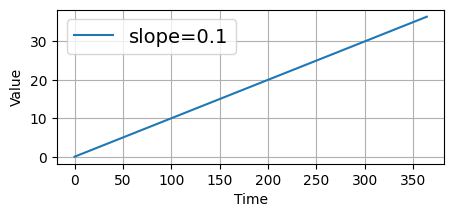

In [ ]:
# TREND describes the general tendency of the values to go up or down as time progresses.
time = np.arange(365)
slope = 0.1
series = trend(time, slope)
plot_series(time, series, label=[f'slope={slope}'])

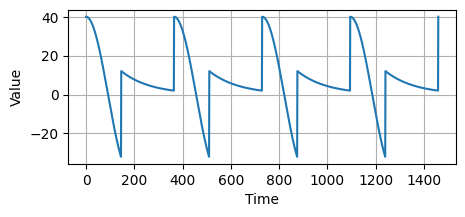

In [ ]:
# SEASONALITY refers to a recurring pattern at regular time intervals.
time = np.arange(4 * 365 + 1)
period = 365
amplitude = 40
series = seasonality(time, period=period, amplitude=amplitude)

plot_series(time, series)

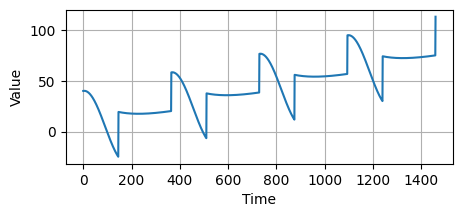

In [ ]:
# A time series can also contain both trend and seasonality.
slope = 0.05
period = 365
amplitude = 40
series = trend(time, slope) + seasonality(time, period=period, amplitude=amplitude)

plot_series(time, series)

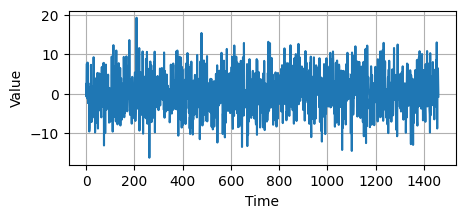

In [ ]:
# NOISE
noise_level = 5
noise_signal = noise(time, noise_level=noise_level, seed=42)

plot_series(time, noise_signal)

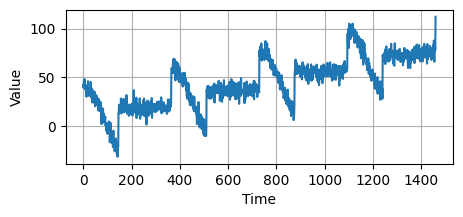

In [ ]:
# Add noise to our series
series += noise_signal
plot_series(time, series)

**Autocorrelation** means that measurements at a given time step is a function of previous time steps.

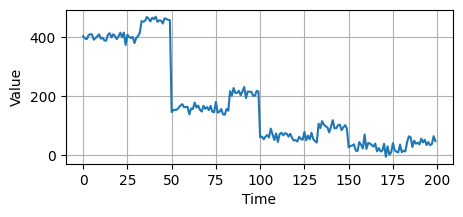

In [ ]:
# Use time steps from previous section and generate autocorrelated data
series = autocorrelation_temp(time, amplitude=10, seed=42)
# Plot the first 200 elements to see the pattern more clearly
plot_series(time[:200], series[:200])

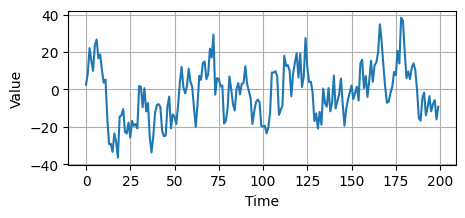

In [ ]:
# Use time steps from previous section and generate autocorrelated data with more straightforward function
series = autocorrelation(time, amplitude=10, seed=42)
# Plot the results
plot_series(time[:200], series[:200])

Another autocorrelated time series you might encounter is one where it decays predictably after **random spikes**.  
You will first define the function that generates these spikes below.


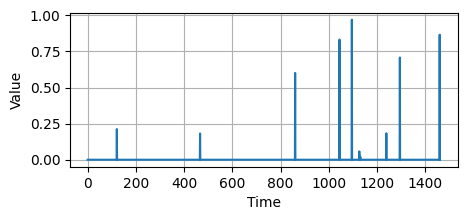

In [ ]:
# use the function above to generate a series with 10 random impulses
impulses_signal = impulses(time, num_impulses=10, seed=42)
plot_series(time, impulses_signal)


You can then use the function to generate the decay after the spikes. Here is one example that generates the next value from the previous time step (i.e. `t-1`, where `t` is the current time step):

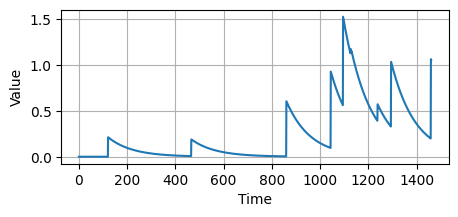

In [ ]:
# use the impulses function to generate the decay after the spikes
# it will generate the next value from the previous time step (i.e. t-1, where t is the current time step)
series = autocorrelation_impulses(impulses_signal, {1: 0.99})
plot_series(time, series)

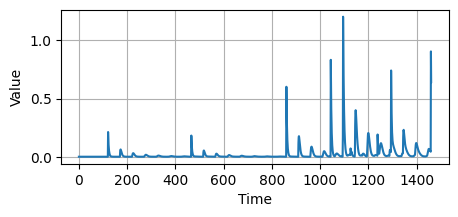

In [ ]:
# another example where the next values are computed from those in `t-1` and `t-50`
series = autocorrelation_impulses(impulses_signal, {1: 0.70, 50: 0.2})
plot_series(time, series)

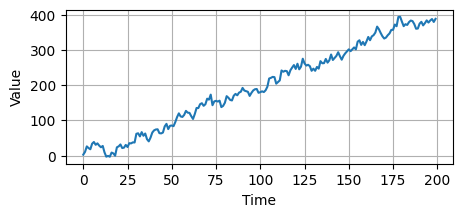

In [ ]:
# autocorrelated data can also ride a trend line
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])

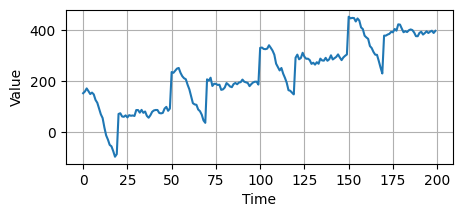

In [ ]:
# similarly, seasonality can also be added to this data
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])

**Non-stationary Time Series**  
Big events can alter the trend or seasonal behavior of the data and it can cause the time series to break an expected pattern

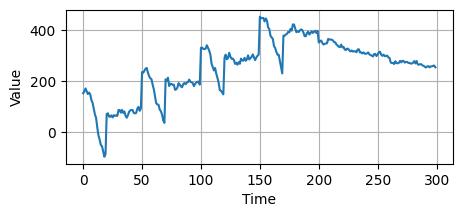

In [ ]:
# Generate data with positive trend
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
# Generate data with negative trend
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
# Splice the downward trending data into the first one at time step = 200
series[200:] = series2[200:]

plot_series(time[:300], series[:300])

In cases like this, we may want to train our model on the later steps (i.e. starting at t=200) since these present a stronger predictive signal to future time steps

# Forecasting

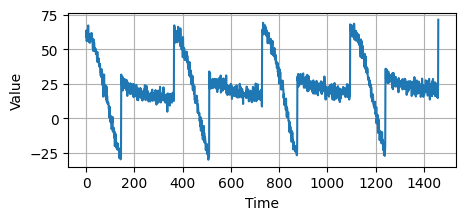

In [ ]:
# GENERATE SYNTHETIC DATA

# # Parameters
# time = np.arange(4 * 365 + 1, dtype="float32")
# baseline = 10
# amplitude = 40
# slope = 0.05
# noise_level = 5

# # Create the series
# series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# # Update with noise
# series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(G.TIME, G.SERIES)

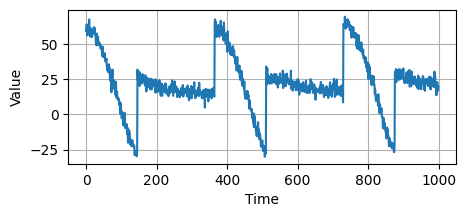

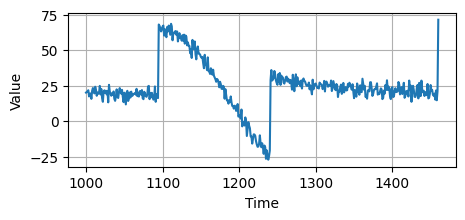

In [ ]:
# split data
time_train = G.TIME[:G.SPLIT_TIME]
x_train = G.SERIES[:G.SPLIT_TIME]
time_valid = G.TIME[G.SPLIT_TIME:]
x_valid = G.SERIES[G.SPLIT_TIME:]

# plot train and validation datasets
plot_series(time_train, x_train)
plot_series(time_valid, x_valid)

## Naive forecast

As a baseline, you can do a naive forecast where you assume that the next value will be the same as the previous time step. You can slice the original series like below and print some values as a sanity check. The next time step value should be identical to the ground truth at the previous time step.

ground truth at time step 100: 66.63211059570312
prediction at time step 101: 66.63211059570312


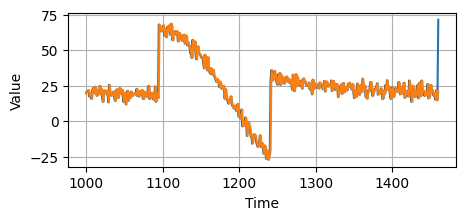

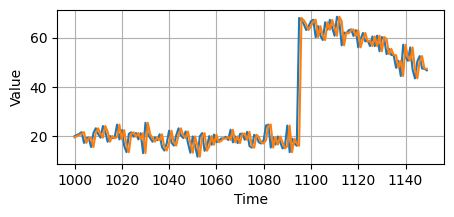

MSE: 35.64579
MAE: 3.7730849


In [ ]:
# naive forecast simply copying the training data at time t-1
naive_forecast = G.SERIES[G.SPLIT_TIME - 1:-1]
time_step = 100

print(f'ground truth at time step {time_step}: {x_valid[time_step]}')
print(f'prediction at time step {time_step + 1}: {naive_forecast[time_step + 1]}')

plot_series(time_valid, (x_valid, naive_forecast))

# zooming in
plot_series(time_valid, (x_valid, naive_forecast), start=0, end=150) # the naive forecast lags 1 step behind the time series

# metrics
print('MSE:', tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print('MAE:', tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

## Moving average

Using moving average technique we sum up a series of time steps and the average will be the prediction for the next time step.

  
*(For example, the average of the measurements at time steps 1 to 10 will be the forecast for time step 11, then the average for time steps 2 to 11 will be the forecast for time step 12, and so on)*

In [ ]:
def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []

    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
      forecast.append(series[time:time + window_size].mean())

    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast

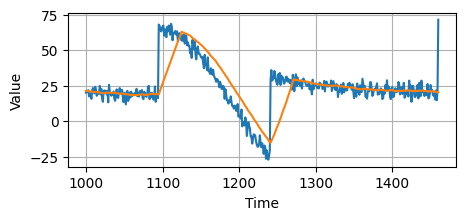

MSE: 144.78374
MAE: 7.4788346


In [ ]:
moving_avg = moving_average_forecast(G.SERIES, 30)[G.SPLIT_TIME - 30:]

plot_series(time_valid, (x_valid, moving_avg))

print('MSE:', tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print('MAE:', tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())
# worse than naive forecast

## Differencing

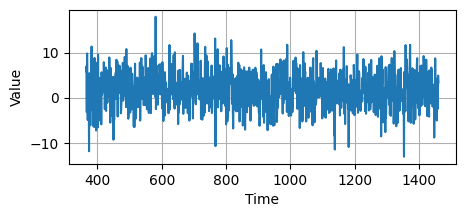

In [ ]:
# since the seasonality period is 365 days, we subtract the values at t-365 from original series
diff_series = (G.SERIES[365:] - G.SERIES[:-365])
# truncate the first 365 time steps
diff_time = G.TIME[365:]

plot_series(diff_time, diff_series)

We removed trend and seasonality.
Now we can try to use moving average again.  
`diff_series` is the ground truth while `diff_moving_avg` is the prediction array. We will slice these accordingly to correspond to the validation set time steps before comparing.

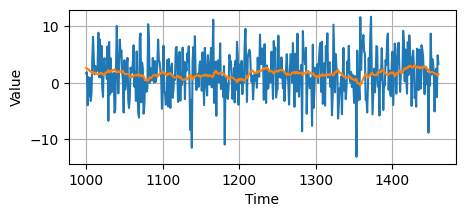

In [ ]:
# generate moving average from the time differenced dataset
diff_moving_avg = moving_average_forecast(diff_series, 30)
# slice the prediction points that corresponds to the validation set time steps
diff_moving_avg = diff_moving_avg[G.SPLIT_TIME - 365 - 30:]
# slice the ground truth points that corresponds to the validation set time steps
diff_series = diff_series[G.SPLIT_TIME - 365:]

plot_series(time_valid, (diff_series, diff_moving_avg))

Now we will bring bring back the trend and seasonality by adding the past values from `t – 365`

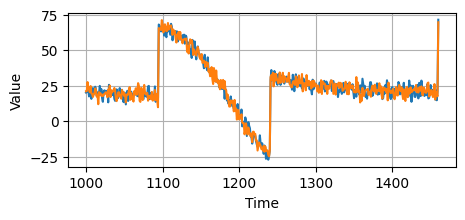

In [ ]:
# add the trend and seasonality from the original series
diff_moving_avg_plus_past = G.SERIES[G.SPLIT_TIME - 365:-365] + diff_moving_avg

plot_series(time_valid, (x_valid, diff_moving_avg_plus_past))

In [ ]:
print('MSE:', tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print('MAE:', tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

MSE: 16.239315
MAE: 3.1826534


It is a bit better than naive forecast. However, the forecasts look a bit too random because we're adding past values which are already noisy.  
The time differenced signal is also noisy so adding these raw past values can compound this problem. To remedy that, we can use a moving averaging on historic values to smooth out some of this noise.

## Smoothing

We can use the same `moving_average_forecast()` function to smooth out past values before adding them back to the time differenced moving average. There are two ways to do this:

* Trailing windows - This refers to getting the mean of past values to smooth out the value at the current time step. For example, getting the average of `t=0` to `t=6` to get the smoothed data point at **`t=6`**.

* Centered windows - This refers to getting the mean of past *and future* values to smooth out the value at the current time step. For example, getting the average of `t=0` to `t=6` to get the smoothed data point at **`t=3`**.

The code below will use the centered windows approach and you will notice it in the slicing of the `series` array. It is shifted by `370` steps and the window size is `11`. To get the smooth data point at `t=1000` (i.e. start of the validation set), it will average the measurements at `t=995` to `t=1005`.

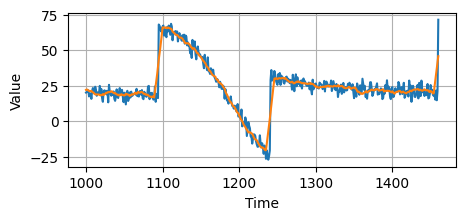

MSE: 25.020035
MAE: 3.2143004


In [ ]:
# Smooth the original series before adding the time differenced moving average
diff_moving_avg_plus_smooth_past = moving_average_forecast(G.SERIES[G.SPLIT_TIME - 370:-359], 11) + diff_moving_avg

plot_series(time_valid, (x_valid, diff_moving_avg_plus_smooth_past))

print('MSE:', tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print('MAE:', tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

# Preparing Time Series Features and Labels

## Windowing the data

[window()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) method here will take 5 elements per window (`size`) and you move this window 1 element at a time (`shift`).  
*One caveat to using this method is that each window returned is a [Dataset](https://www.tensorflow.org/guide/data#dataset_structure) in itself. This is a Python iterable and, as of the current version (TF 2.8), it won't show the elements if you use the `print()` method on it. It will just show a description of the data structure (e.g. `<_VariantDataset shapes: (), types: tf.int64>`).*

In [ ]:
# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.range(10)

# Window the data
dataset = dataset.window(size=5, shift=1)

for window_dataset in dataset:
  print(window_dataset)

for window_dataset in dataset:
  print([item.numpy() for item in window_dataset])

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]
[6, 7, 8, 9]
[7, 8, 9]
[8, 9]
[9]


The resulting sets are not sized evenly because there are no more elements after the number `9`. We can use the `drop_remainder` flag to make sure that only 5-element windows are retained.

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(size=5, shift=1, drop_remainder=True)

for window_dataset in dataset:
  print([item.numpy() for item in window_dataset])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


## Flatten the window

We want to prepare the windows to be [tensors](https://www.tensorflow.org/guide/tensor) instead of the `Dataset` structure. It can be done by feeding a mapping function to the [flat_map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#flat_map) method. This function will be applied to each window and the results will be [flattened into a single dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#flatten_a_dataset_of_windows_2).   
The code below will put all elements of a window into a single batch then flatten the result.

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)

# flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


## Group into features and labels


In [ ]:
# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

for x,y in dataset:
  print(f"x: {x.numpy()}, y: {y.numpy()}", )

x: [0 1 2 3], y: 4
x: [1 2 3 4], y: 5
x: [2 3 4 5], y: 6
x: [3 4 5 6], y: 7
x: [4 5 6 7], y: 8
x: [5 6 7 8], y: 9


## Shuffle the data

It is good practice to shuffle dataset to reduce *sequence bias* while training model. This refers to the neural network overfitting to the order of inputs and consequently, it will not perform well when it does not see that particular order when testing.

*Using [shuffle()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) method, the `buffer_size` parameter is required and number equal or greater than the total number of elements should be used for better shuffling. Since the total number of windows in the dataset is 6, we can choose a number >= 6*

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# Shuffle the windows
dataset = dataset.shuffle(buffer_size=10)

for x,y in dataset:
  print(f"x: {x.numpy()}, y: {y.numpy()}", )

x: [1 2 3 4], y: 5
x: [0 1 2 3], y: 4
x: [2 3 4 5], y: 6
x: [5 6 7 8], y: 9
x: [3 4 5 6], y: 7
x: [4 5 6 7], y: 8


## Create batches for training

We need to group windows into batches.  
  
*Using [batch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) method we need to specify the batch size and it will return a batched dataset with that number of windows*  
  
*As a rule of thumb, it is also good to specify a [prefetch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) step. This optimizes the execution time when the model is already training. By specifying a prefetch `buffer_size` of `1`, Tensorflow will prepare the next one batch in advance (i.e. putting it in a buffer) while the current batch is being consumed by the model.  
https://towardsdatascience.com/optimising-your-input-pipeline-performance-with-tf-data-part-1-32e52a30cac4#Prefetching*

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
dataset = dataset.shuffle(buffer_size=10)

# Create batches of windows
dataset = dataset.batch(2).prefetch(1)

for x,y in dataset:
  print(f"x: {x.numpy()}, y: {y.numpy()}", )

x: [[0 1 2 3]
 [2 3 4 5]], y: [4 6]
x: [[4 5 6 7]
 [1 2 3 4]], y: [8 5]
x: [[5 6 7 8]
 [3 4 5 6]], y: [9 7]


# Single layer NN

In [ ]:
# split dataset
time_train = G.TIME[:G.SPLIT_TIME]
x_train = G.SERIES[:G.SPLIT_TIME]
time_valid = G.TIME[G.SPLIT_TIME:]
x_valid = G.SERIES[G.SPLIT_TIME:]

In [ ]:
# prepare features and labels
dataset = windowed_dataset(x_train, G.WINDOW_SIZE, G.BATCH_SIZE, G.SHUFFLE_BUFFER_SIZE)

# print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


In [ ]:
# build the single layer neural network
l0 = tf.keras.layers.Dense(1, input_shape=[G.WINDOW_SIZE])
model_simplest = tf.keras.models.Sequential([l0])
model_simplest.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

print("Layer weights: \n {} \n".format(l0.get_weights())) # initial layer weights
model_simplest.summary()
# 1st array - weights, 2nd array ([0.] - bias)

Layer weights: 
 [array([[ 0.50568956],
       [ 0.52101094],
       [ 0.11242127],
       [ 0.41102195],
       [ 0.2251488 ],
       [ 0.06409943],
       [ 0.38760316],
       [ 0.28810126],
       [ 0.34419274],
       [ 0.262236  ],
       [ 0.03817725],
       [ 0.07794124],
       [-0.05378455],
       [-0.09471616],
       [ 0.17822915],
       [-0.1787472 ],
       [-0.23801565],
       [-0.01659602],
       [-0.10870525],
       [-0.16930225]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sys.exit("Execution stopped. Please run cells selectively.")

SystemExit: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# train model
model_simplest.fit(dataset, epochs=100, verbose=0)

In [ ]:
print("Layer weights {}".format(l0.get_weights()))

We can generate a model prediction by passing a batch of data windows. If we will be slicing a window from the original `series` array, we will need to add a batch dimension before passing it to the model. That can be done by indexing with the [`np.newaxis`](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis) constant or using the [`np.expand_dims()`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) method.

In [ ]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')
# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}\n')

print(f'model prediction: {model_simplest.predict(series[0:20][np.newaxis])}')

In [ ]:
# make validation predictions
forecast = []
# Use the model to predict data points per window size
for time in range(len(G.SERIES) - G.WINDOW_SIZE):
  forecast.append(model_simplest.predict(G.SERIES[time:time + G.WINDOW_SIZE][np.newaxis], verbose=0))
# Slice the points that are aligned with the validation set
forecast = forecast[G.SPLIT_TIME - G.WINDOW_SIZE:]

In [ ]:
# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')
# Convert to a numpy array and drop single dimensional axes in order to put data into plot_series function
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_valid, (x_valid, results))

# Compute the metrics
print('MSE:', tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print('MAE:', tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

# Deep NN

In [ ]:
# prepare features and labels
dataset = windowed_dataset(x_train, G.WINDOW_SIZE, G.BATCH_SIZE, G.SHUFFLE_BUFFER_SIZE)

## Baseline model

In [ ]:
# Build the model
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[G.WINDOW_SIZE], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])
model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

model_baseline.summary()

In [ ]:
sys.exit("Execution stopped. Please run cells selectively.")

In [ ]:
model_baseline.fit(dataset, epochs=100, verbose=0)

In [ ]:
# make validation predictions
forecast = []
# Reduce the original series
forecast_series = G.SERIES[G.SPLIT_TIME - G.WINDOW_SIZE:]
# Use the model to predict data points per window size
for time in range(len(forecast_series) - G.WINDOW_SIZE):
  forecast.append(model_baseline.predict(forecast_series[time:time + G.WINDOW_SIZE][np.newaxis], verbose=0))
# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
# Compute the metrics
print('MSE:', tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print('MAE:', tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

## Tune learning rate

Let's declare a [learning rate scheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) callback. This will allow us dynamically set the learning rate based on the epoch number during training. Here we will pass a lambda function to declare the value of the learning rate. It will start at `1e-8` at epoch 0 and is scaled by `10**(epoch / 20)` as the training goes on.

In [ ]:
sys.exit("Execution stopped. Please run cells selectively.")

In [ ]:
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[G.WINDOW_SIZE], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model_tune.compile(loss="mse", optimizer=optimizer)

In [ ]:
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

In [ ]:
lrs = 1e-7 * (10 ** (np.arange(100) / 20))                # define the learning rate array
plt.figure(figsize=(5, 2))                                # set the figure size
plt.grid(True)                                            # set the grid
plt.semilogx(lrs, history.history["loss"])                # plot the loss in log scale
plt.tick_params('both', length=10, width=1, which='both') # increase the tickmarks size
plt.axis([1e-8, 1e-3, 0, 300])                            # set the plot boundaries

Let's pick the learning rate which is close to the minimum but still relatively stable and use it.

In [ ]:
sys.exit("Execution stopped. Please run cells selectively.")

In [ ]:
# train model with tuned learning rate
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[G.WINDOW_SIZE], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)
model_tune.compile(loss="mse", optimizer=optimizer)
history = model_tune.fit(dataset, epochs=100, verbose=0)

In [ ]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.figure(figsize=(5, 2))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

# cut initial epochs
plt.figure(figsize=(5, 2))
plt.plot(epochs[5:], loss[5:], label='Training Loss')
plt.show()

In [ ]:
# make validation predictions
forecast = []
# Reduce the original series
forecast_series = G.SERIES[G.SPLIT_TIME - G.WINDOW_SIZE:]
# Use the model to predict data points per window size
for time in range(len(forecast_series) - G.WINDOW_SIZE):
  forecast.append(model_tune.predict(forecast_series[time:time + G.WINDOW_SIZE][np.newaxis], verbose=0))
# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
# Compute the metrics
print('MSE:', tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print('MAE:', tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

# RNN

`SimpleRNN` layers expect a 3-dimensional tensor input with the shape `[batch, timesteps, feature`] ([documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN#call_arguments)).  
We need to reshape our window from (32, 20) to (32, 20, 1), 20 datapoints in the window will be mapped to 20 timesteps of the RNN. We can do this reshaping in a separate cell but we can also do this within the model itself by using [Lambda](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda) layers. Our first layer defines a lambda function that adds a dimension at the last axis of the input. For the `input_shape`, we can specify `None` if we want the model to be more flexible with the number of timesteps. Alternatively, we can set it to `window_size` if we want to set the `timesteps` dimension to the expected size of our data windows.

`SimpleRNN` uses *tanh* by default and that has an output range of `[-1,1]`. We will use another `Lambda()` layer to scale the output by 100 before it adjusts the layer weights (because our values are between 100 and -100)

In [ ]:
def create_rnn_model():
  return tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[G.WINDOW_SIZE]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_rnn_tune = create_rnn_model()
model_rnn_tune.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 20, 1)             0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 20, 40)            1680      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_4 (Dense)             (None, 1)                 41        
                                                                 
 lambda_7 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#@title tune the learning rate
history_rnn_tune = adjust_learning_rate(dataset, model_rnn_tune, tf.keras.losses.Huber())

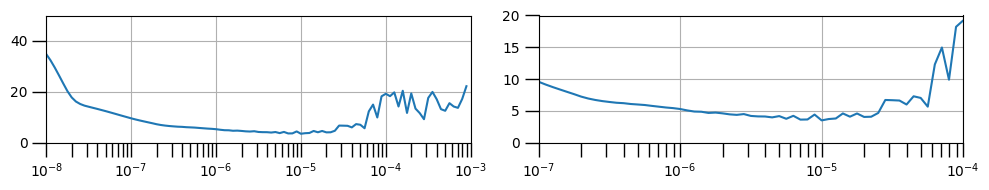

In [ ]:
plot_learning_rate(history_rnn_tune)

In [ ]:
#@title train model
model_rnn = create_rnn_model()
learning_rate = 1e-6
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_rnn.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history_rnn = model_rnn.fit(dataset,epochs=100, verbose=0)

15/15 [==============================] - 0s 9ms/step


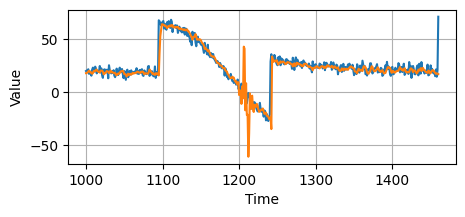

66.551994
4.0072017


In [ ]:
#@title predict
forecast_series = G.SERIES[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
forecast = model_forecast(model_rnn, forecast_series, G.WINDOW_SIZE, G.BATCH_SIZE)
results = forecast.squeeze() # drop single dimensional axes

plot_series(time_valid, (x_valid, results))

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

# LSTM

In [ ]:
def create_lstm_model():
  return tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[G.WINDOW_SIZE]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_lstm_tune = create_lstm_model()
model_lstm_tune.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_16 (Lambda)          (None, 20, 1)             0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 20, 64)           8704      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
 lambda_17 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-trai

In [ ]:
#@title tune learning rate
history_lstm_tune = adjust_learning_rate(dataset, model_lstm_tune, tf.keras.losses.Huber())

Epoch 1/100
31/31 - 6s - loss: 41.4362 - mae: 41.9362 - lr: 1.0000e-08 - 6s/epoch - 209ms/step
Epoch 2/100
31/31 - 0s - loss: 40.7680 - mae: 41.2680 - lr: 1.1220e-08 - 354ms/epoch - 11ms/step
Epoch 3/100
31/31 - 0s - loss: 39.9613 - mae: 40.4613 - lr: 1.2589e-08 - 335ms/epoch - 11ms/step
Epoch 4/100
31/31 - 0s - loss: 39.0554 - mae: 39.5554 - lr: 1.4125e-08 - 367ms/epoch - 12ms/step
Epoch 5/100
31/31 - 0s - loss: 38.0438 - mae: 38.5438 - lr: 1.5849e-08 - 356ms/epoch - 11ms/step
Epoch 6/100
31/31 - 0s - loss: 36.9117 - mae: 37.4117 - lr: 1.7783e-08 - 366ms/epoch - 12ms/step
Epoch 7/100
31/31 - 0s - loss: 35.6513 - mae: 36.1511 - lr: 1.9953e-08 - 354ms/epoch - 11ms/step
Epoch 8/100
31/31 - 0s - loss: 34.2482 - mae: 34.7478 - lr: 2.2387e-08 - 349ms/epoch - 11ms/step
Epoch 9/100
31/31 - 0s - loss: 32.6932 - mae: 33.1931 - lr: 2.5119e-08 - 370ms/epoch - 12ms/step
Epoch 10/100
31/31 - 0s - loss: 30.9665 - mae: 31.4665 - lr: 2.8184e-08 - 341ms/epoch - 11ms/step
Epoch 11/100
31/31 - 0s - loss:

In [ ]:
#@title plot learning rate
plot_learning_rate(history_lstm_tune)

In [ ]:
#@title train model

# tf.keras.backend.clear_session() # reset states generated by Keras

model_lstm = create_lstm_model()
learning_rate = 4e-5
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_lstm.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history_lstm = model_lstm.fit(dataset,epochs=100, verbose=0)

15/15 [==============================] - 2s 15ms/step


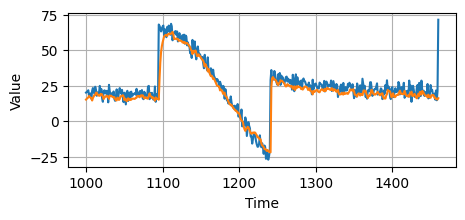

41.485764
3.9203317


In [ ]:
#@title predict
forecast_series = G.SERIES[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
forecast = model_forecast(model_lstm, forecast_series, G.WINDOW_SIZE, G.BATCH_SIZE)
results = forecast.squeeze() # drop single dimensional axes

plot_series(time_valid, (x_valid, results))

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

# Convolutions

## Create model

In [ ]:
dataset = windowed_dataset(x_train, G.WINDOW_SIZE, 16, G.SHUFFLE_BUFFER_SIZE)

[Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)

Important [argument](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D#args) is the `padding`. For time series data, it is a good practice to not let computations for a particular time step be affected by values into the future:

* For time series window with values: `[1, 2, 3, 4, 5]` the value `1` is at `t=0`, `2` is at `t=1`, etc.
* If you have a 1D kernel of size `3`, then the first convolution will be for the values at `[1, 2, 3]` which are values for `t=0` to `t=2`.
* When you pass this to the first timestep of the `LSTM` after the convolution, it means that the value at `t=0` of the LSTM depends on `t=1` and `t=2` which are values into the future.
* For time series data, you want computations to only rely on current and previous time steps.
* One way to do that is to pad the array depending on the kernel size and stride. For a kernel size of 3 and stride of 1, the window can be padded as such: `[0, 0, 1, 2, 3, 4, 5]`. `1` is still at `t=0` and two zeroes are prepended to simulate values in the past.
* This way, the first stride will be at `[0, 0, 1]` and this does not contain any future values when it is passed on to subsequent layers.

The `Conv1D` layer does this kind of padding by setting `padding=causal` and you'll see that below.

In [ ]:
# tf.keras.backend.clear_session()

def create_conv_lstm_model(window_size=None):
  return tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu", input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_conv_lstm_tune = create_conv_lstm_model(G.WINDOW_SIZE)
model_conv_lstm_tune.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 20, 64)            256       
                                                                 
 lstm_18 (LSTM)              (None, 20, 32)            12416     
                                                                 
 lstm_19 (LSTM)              (None, 32)                8320      
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
 lambda_25 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


## Tune model

In [ ]:
# Get initial weights
init_weights = model_conv_lstm_tune.get_weights()

In [ ]:
history_conv_lstm_tune = adjust_learning_rate(dataset, model_conv_lstm_tune, tf.keras.losses.Huber())

Epoch 1/100
62/62 - 6s - loss: 21.6919 - mae: 22.1917 - lr: 1.0000e-08 - 6s/epoch - 105ms/step
Epoch 2/100
62/62 - 0s - loss: 19.6550 - mae: 20.1541 - lr: 1.1220e-08 - 437ms/epoch - 7ms/step
Epoch 3/100
62/62 - 0s - loss: 17.3278 - mae: 17.8259 - lr: 1.2589e-08 - 438ms/epoch - 7ms/step
Epoch 4/100
62/62 - 0s - loss: 14.8900 - mae: 15.3780 - lr: 1.4125e-08 - 435ms/epoch - 7ms/step
Epoch 5/100
62/62 - 0s - loss: 12.9982 - mae: 13.4820 - lr: 1.5849e-08 - 467ms/epoch - 8ms/step
Epoch 6/100
62/62 - 0s - loss: 12.0749 - mae: 12.5559 - lr: 1.7783e-08 - 450ms/epoch - 7ms/step
Epoch 7/100
62/62 - 0s - loss: 11.6928 - mae: 12.1716 - lr: 1.9953e-08 - 447ms/epoch - 7ms/step
Epoch 8/100
62/62 - 0s - loss: 11.4992 - mae: 11.9765 - lr: 2.2387e-08 - 439ms/epoch - 7ms/step
Epoch 9/100
62/62 - 0s - loss: 11.3400 - mae: 11.8170 - lr: 2.5119e-08 - 445ms/epoch - 7ms/step
Epoch 10/100
62/62 - 0s - loss: 11.1691 - mae: 11.6454 - lr: 2.8184e-08 - 452ms/epoch - 7ms/step
Epoch 11/100
62/62 - 0s - loss: 10.9670 

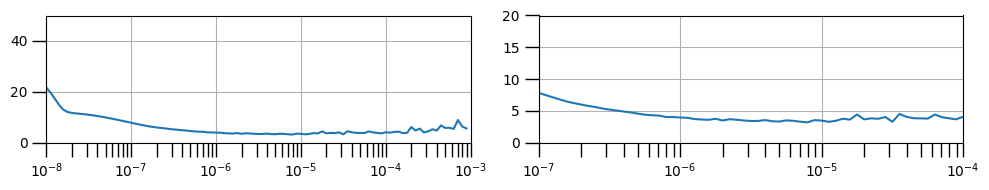

In [ ]:
plot_learning_rate(history_conv_lstm_tune)

## Train model

In [ ]:
# tf.keras.backend.clear_session()

model_conv_lstm = create_conv_lstm_model()
learning_rate = 8e-6
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_conv_lstm.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history_conv_lstm = model_lstm.fit(dataset,epochs=100, verbose=0)

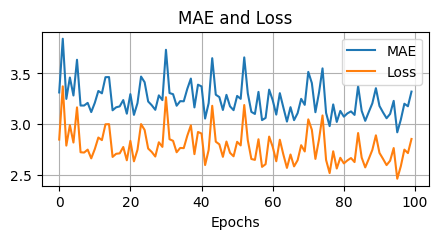

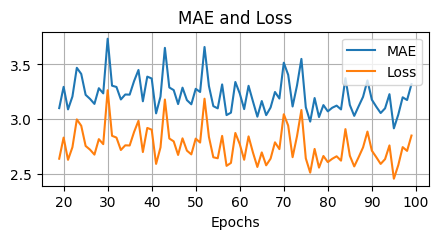

In [ ]:
def plot_series_new_function(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(5, 2))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

# Get mae and loss from history log
mae=history_conv_lstm.history['mae']
loss=history_conv_lstm.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series_new_function(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='Epochs',
    legend=['MAE', 'Loss']
)

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series_new_function(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='Epochs',
    legend=['MAE', 'Loss']
)

## Model prediction

15/15 [==============================] - 0s 8ms/step


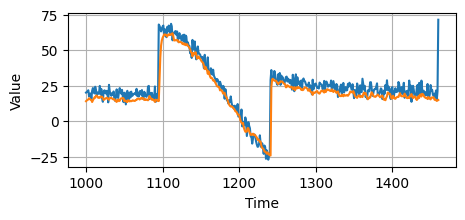

47.09598
4.4593916


In [ ]:
forecast_series = G.SERIES[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
forecast = model_forecast(model_lstm, forecast_series, G.WINDOW_SIZE, G.BATCH_SIZE)
results = forecast.squeeze() # drop single dimensional axes

plot_series(time_valid, (x_valid, results))

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

## Train with callback

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when a certain metric is met

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check the validation set MAE
    if(logs.get('val_mae') < 5.2):

      # Stop if threshold is met
      print("\nRequired val MAE is met so cancelling training!")
      self.model.stop_training = True

# Instantiate the class
callbacks = myCallback()

# ...